In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def shuffle_examples(X,y):
  p = np.random.permutation(len(X))
  return X[p],y[p]

def split_train_validation_test(X,y,p_t,p_tv):
  n = int(p_t*len(X))
  m = int(p_tv*len(X))
  return X[:n],y[:n],X[n:m],y[n:m],X[m:],y[m:]   

def scale(x):
  mu = np.mean(x,axis=0)
  st = np.std(x,axis=0)
  return (x-mu)/st,mu,st  

def sigmoid(x):
  return 1/(1+np.exp(-x))

def relu(x):
  return np.maximum(0,x)  

def softmax(X):
  return np.exp(X)/(np.sum(np.exp(X),axis=1).reshape(-1,1))   

def sigmoid_p(x):
  return sigmoid(x)*(1-sigmoid(x))

def relu_p(x):
  return 1*(x >= 0)    

def error(y,y_hat):
  return -np.sum(y*np.log(y_hat)+(1-y)*np.log(1-y_hat))/len(y)

def error_softmax(y,y_hat):
  return -np.sum(y*np.log(y_hat))/len(y)
  
def error_reg(y,y_hat,W,la):
  J_reg = -np.sum(y*np.log(y_hat)+(1-y)*np.log(1-y_hat))/len(y)
  for l in range(1,len(W)):
    J_reg = J_reg + la*np.sum(W[l]**2)/len(y)
  return J_reg      

def error_softmax_reg(y,y_hat,W,la):
  J_reg = -np.sum(y*np.log(y_hat))/len(y)
  for l in range(1,len(W)):
    J_reg = J_reg + la*np.sum(W[l]**2)/len(y)
  return J_reg   
  
def accuracy_recall_precision(y_hat,y):
  y_hat_cat = 1*(y_hat > 0.5)
  correct_predictions = np.sum(y_hat_cat == y)
  predictions = len(y)
  true_positives = np.sum((y_hat_cat == 1) & (y == 1))
  positives = np.sum(y)
  predicted_positives = np.sum(y_hat_cat)
  accuracy = correct_predictions/predictions
  recall = true_positives/positives
  precision = true_positives/predicted_positives
  return accuracy, recall, precision  

# y is a one dimensional array y_1d = [0,2,1,3,0,2] (the categories of the examples)
# y_hat is 2d
def accuracy_softmax(y_hat,y_1d):
  y_hat_1d = np.argmax(y_hat,axis=1)
  correct_predictions = np.sum(y_hat_1d == y_1d)
  predictions = len(y_1d)
  accuracy = correct_predictions/predictions
  return accuracy
  
def h(x,act):
  if act == 'sigmoid':
    return sigmoid(x)
  if act == 'relu':
    return relu(x)
  if act == 'identity':
    return x
  if act == 'tanh':
    return np.tanh(x)
  if act == 'softmax':
    return softmax(x)  
  return 'Problem' 

def h_p(x,act):
  if act == 'sigmoid':
    return sigmoid_p(x)
  if act == 'relu':
    return relu_p(x)
  if act == 'identity':
    return 1
  if act == 'tanh':
    return 1/(np.cosh(x))**2
  return 'Problem'  

def As_Zs(X,W,b,act):
  A = [X]
  Z = [0]
  for l in range(1,len(b)):
    Z.append(np.matmul(A[-1],W[l])+b[l])
    A.append(h(Z[-1],act[l]))
  return A,Z 

def gradients(A,Z,act,W,y):
  y_hat = A[-1]
  l = len(W)-1
  DJ_DW = []
  DJ_Db = []
  DJ_DZ = (y_hat - y.reshape(-1,1))/len(y)
  while l > 1:
    DJ_DA = np.matmul(DJ_DZ,W[l].T)
    DJ_DW.insert(0,np.matmul(A[l-1].T,DJ_DZ)) 
    DJ_Db.insert(0,np.sum(DJ_DZ,axis=0))
    DJ_DZ = DJ_DA*h_p(Z[l-1],act[l-1])
    l = l-1
  DJ_DA = np.matmul(DJ_DZ,W[1].T)
  DJ_DW.insert(0,np.matmul(A[0].T,DJ_DZ)) 
  DJ_Db.insert(0,np.sum(DJ_DZ,axis=0)) 
  DJ_DW.insert(0,0) 
  DJ_Db.insert(0,0)  
  return DJ_DW,DJ_Db  

# y is 2d
def gradients_softmax(A,Z,act,W,y):
  y_hat = A[-1]
  l = len(W)-1
  DJ_DW = []
  DJ_Db = []
  DJ_DZ = (y_hat - y)/len(y)
  while l > 1:
    DJ_DA = np.matmul(DJ_DZ,W[l].T)
    DJ_DW.insert(0,np.matmul(A[l-1].T,DJ_DZ)) 
    DJ_Db.insert(0,np.sum(DJ_DZ,axis=0))
    DJ_DZ = DJ_DA*h_p(Z[l-1],act[l-1])
    l = l-1
  DJ_DA = np.matmul(DJ_DZ,W[1].T)
  DJ_DW.insert(0,np.matmul(A[0].T,DJ_DZ)) 
  DJ_Db.insert(0,np.sum(DJ_DZ,axis=0)) 
  DJ_DW.insert(0,0) 
  DJ_Db.insert(0,0)  
  return DJ_DW,DJ_Db  

def update_parameters(W,b,DJ_DW,DJ_Db,c):
  for l in range(1,len(b)):
    W[l] = W[l] - c*DJ_DW[l]
    b[l] = b[l] - c*DJ_Db[l]
  return W, b  

def update_parameters_reg(W,b,DJ_DW,DJ_Db,c,m,la):
  for l in range(1,len(b)):
    W[l] = W[l] - c*DJ_DW[l] - 2*c*la*W[l]/m
    b[l] = b[l] - c*DJ_Db[l] 
  return W, b  

def initialize_W_and_b(n):
  W = [0]
  b = [0]
  for l in range(1,len(n)):
    W.append(np.random.randn(n[l-1],n[l])/np.sqrt(n[l-1]))
    b.append(np.zeros(n[l]))
  return W, b 

def steepest(n,act,X,y,epochs,c):
  W, b = initialize_W_and_b(n)
  J_list = []
  for i in range(epochs):
    A, Z = As_Zs(X,W,b,act)
    y_hat = A[-1]
    J_list.append(error(y,y_hat.reshape(-1)))
    DJ_DW, DJ_Db = gradients(A,Z,act,W,y)
    W, b = update_parameters(W,b,DJ_DW,DJ_Db,c)
  return W, b, J_list   

def steepest_softmax(n,act,X,y,epochs,c):
  W, b = initialize_W_and_b(n)
  J_list = []
  for i in range(epochs):
    if i%100 == 0:
      print(i)
    A, Z = As_Zs(X,W,b,act)
    y_hat = A[-1]
    J_list.append(error_softmax(y,y_hat))
    DJ_DW, DJ_Db = gradients_softmax(A,Z,act,W,y)
    W, b = update_parameters(W,b,DJ_DW,DJ_Db,c)
  return W, b, J_list   
  
def steepest_reg(n,act,X,y,epochs,c,la):
  W, b = initialize_W_and_b(n)
  J_list = []
  for i in range(epochs):
    A, Z = As_Zs(X,W,b,act)
    y_hat = A[-1]
    J_list.append(error_reg(y,y_hat.reshape(-1),W,la))
    DJ_DW, DJ_Db = gradients(A,Z,act,W,y)
    W, b = update_parameters_reg(W,b,DJ_DW,DJ_Db,c,len(y),la)
  return W, b, J_list           

def steepest_softmax_reg(n,act,X,y,epochs,c,la):
  W, b = initialize_W_and_b(n)
  J_list = []
  for i in range(epochs):
    A, Z = As_Zs(X,W,b,act)
    y_hat = A[-1]
    J_list.append(error_softmax_reg(y,y_hat,W,la))
    DJ_DW, DJ_Db = gradients_softmax(A,Z,act,W,y)
    W, b = update_parameters_reg(W,b,DJ_DW,DJ_Db,c,len(y),la)
  return W, b, J_list           

def predict(X,W,b,act):
  A,Z = As_Zs(X,W,b,act)
  return A[-1]

def scale_predict(X,X_train_mean,X_train_std,W,b,act):
  return predict((X-X_train_mean)/X_train_std,W,b,act)

def labels_1d_2d(y,n_c):
  return 1*(np.arange(n_c).reshape(1,n_c) == y.reshape(len(y),1))   

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import h5py

In [ ]:
X_data = h5py.File("/content/drive/MyDrive/Data/signs.h5") 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


In [ ]:
type(X_data)

h5py._hl.files.File

In [ ]:
list(X_data.keys())

['pictures']

In [ ]:
X_i = np.array(X_data['pictures'])

In [ ]:
X_i.shape

(1200, 64, 64, 3)

In [ ]:
y_1d = np.load('/content/drive/MyDrive/Data/labels_signs.npy') 

In [ ]:
y_1d.shape

(1200,)

y =  0


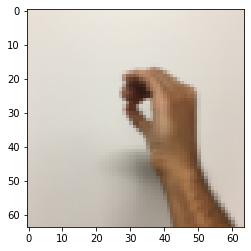

In [ ]:
i = 1112
plt.imshow(X_i[i])
print ("y = ",y_1d[i])

In [ ]:
X_i,y_1d = shuffle_examples(X_i,y_1d)

In [ ]:
def flatten(X):
  return X.reshape(X.shape[0],-1) 

In [ ]:
p_t = 0.8
p_tv = 0.9
X_i_train, y_1d_train, X_i_val, y_1d_val, X_i_test, y_1d_test = split_train_validation_test(X_i,y_1d,p_t,p_tv)

In [ ]:
X_train = flatten(X_i_train)
X_val = flatten(X_i_val)
X_test = flatten(X_i_test)

In [ ]:
n_c = 6
y_2d_train = labels_1d_2d(y_1d_train,n_c)
y_2d_val = labels_1d_2d(y_1d_val,n_c)
y_2d_test = labels_1d_2d(y_1d_test,n_c)

In [ ]:
X_train_scaled, X_train_mean, X_train_std = scale(X_train)

In [ ]:
n = [X_train_scaled.shape[1], 25, 12, 6]
act = [None,'relu','relu','softmax']
c = 0.1
epochs = 200

In [ ]:
W, b, J_list = steepest_softmax(n,act,X_train_scaled,y_2d_train,epochs,c)

0
100


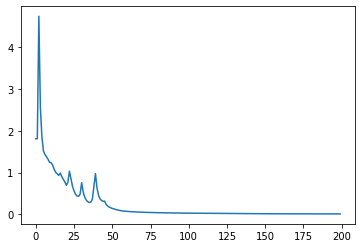

In [ ]:
plt.plot(J_list)

In [ ]:
# y is a one dimensional array y_1d = [0,2,1,3,0,2] (the categories of the examples)
y_hat = scale_predict(X_train,X_train_mean,X_train_std,W,b,act)
print('accuracy =', accuracy_softmax(y_hat,y_1d_train))
print('c e error =',error_softmax(y_2d_train,y_hat))

accuracy = 0.9989583333333333
c e error = 0.00980151686166793


In [ ]:
y_hat = scale_predict(X_val,X_train_mean,X_train_std,W,b,act)
print('accuracy =', accuracy_softmax(y_hat,y_1d_val))
print('c e error =',error_softmax(y_2d_val,y_hat))

accuracy = 0.825
c e error = 0.9620602358825058


In [ ]:
y_hat = scale_predict(X_test,X_train_mean,X_train_std,W,b,act)
print('accuracy =', accuracy_softmax(y_hat,y_1d_test))
print('c e error =',error_softmax(y_2d_test,y_hat))

accuracy = 0.85
c e error = 0.6504390219556277


In [ ]:
la = 0.1
W, b, J_list = steepest_softmax_reg(n,act,X_train_scaled,y_2d_train,epochs,c,la)

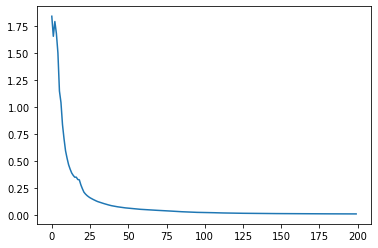

In [ ]:
plt.plot(J_list)

In [ ]:
y_hat = scale_predict(X_train,X_train_mean,X_train_std,W,b,act)
print('accuracy =', accuracy_softmax(y_hat,y_1d_train))
print('c e error =',error_softmax(y_2d_train,y_hat))

accuracy = 1.0
c e error = 0.005259930885579143


In [ ]:
y_hat = scale_predict(X_val,X_train_mean,X_train_std,W,b,act)
print('accuracy =', accuracy_softmax(y_hat,y_1d_val))
print('c e error =',error_softmax(y_2d_val,y_hat))

accuracy = 0.8583333333333333
c e error = 0.6631648109630641


In [ ]:
y_hat = scale_predict(X_test,X_train_mean,X_train_std,W,b,act)
print('accuracy =', accuracy_softmax(y_hat,y_1d_test))
print('c e error =',error_softmax(y_2d_test,y_hat))

accuracy = 0.8666666666666667
c e error = 0.5634759385539615


y =  4
y hat =  [1.25312822e-03 1.16737308e-04 2.69705738e-01 5.76105429e-02
 5.97402294e-01 7.39115603e-02] 4


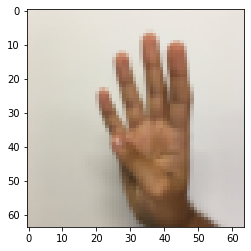

In [ ]:
i = 28
plt.imshow(X_i_test[i])
print ("y = ",y_1d_test[i])
print ("y hat = ",y_hat[i],np.argmax(y_hat[i]))

Text

word

latex good for equations

$$\sum_{i=1}^{10} i^2$$



latex but outside google colab 

open an account in overleaf


1) Pick a data set. 

Kaggle

3) Learn a topic that we did not learn and explain it in the report.

Unsupervised learning (k-means algorithm) 

Reinforced learning (interesting) (chess, video games, finding a path in a maze, robots to clean enviroments)